# Importing Modules

In [1]:
from cytoflow import *
import os

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Modeling Activator Synergy

We consider the simple two-state telegraph model of transcriptional busting

![Telegraph Model](./img/telegraph_model.png)

with gene activation rate $\alpha$, deactivation rate $\beta$, mRNA production rate $k_1$, and mRNA degradation rate $\gamma$. 

This model has a closed form analytical solution, the **zero-inflated Poisson**. Letting

$$\begin{align*}
\beta' &= \frac{\beta}{\beta + \alpha} \\
\lambda &= \frac{k_1}{\gamma}
\end{align*}$$

Then the probability $p(n)$ that a cell has $n$ copies of mRNA is:

$$p(n) = \beta'\text{Pois}(\lambda) + \mathbb{1}_{n=0}(1-\beta')$$

However, we also want to incorporate the reality that the OFF pool has some autofluorescence, which we can interpret as a log-Gaussian distribution with a mean at approximately $0.5 \times 10^6$ and a standard deviation of about one quarter of an order of magnitude. 

We also need to define a relationship between the number of mRNA molecules and the fluorescence beyond background. Prior work using GFP and EGFP seem to indicate that this relationship is roughly linear (Verdaasdonk and Bloom, Meth. Cell. Biol. 2014, Fig. 2C). 

So, we need to determine a saturating number of mRNAs in a given cell. From Connor, it looks like RNA-seq data indicate ON cells have rougly 6000tpkm from Citrine. Bionumbers indicates there are roughly 200,000 mRNA molecules per cell (Shapiro, Biezuner, Linnarsson Nat Rev Genet 2013). So, in total, our ON peak should occur at roughly 1,200 mRNA molecules per cell. 

At 0, we have 6.5 log-fluorescence, and at 1200, we have 8.5 log-fluorescence. So the equation for the log-fluorescence peak from number of mRNA is $c = \theta(n) = \frac{1}{600}n + 6.5$. 

We will assume that for a given number of mRNA molecules $n$ that the distribution of citrine $p(c|n)$ is log-normally distributed with mean $\theta(n)$ and variance given by a free parameter $\sigma_c$. 

So, we'll amend the prior equation to incorporate these things. Let $c$ be the log fluorescence that we want the density of. 

$$\begin{align}
p(c) &= p(c | \text{OFF})p(\text{OFF}) + p(c | \text{ON})p(\text{ON}) \\
&= (1-\beta')\text{Norm}_{\mu=6.5, \sigma=0.175}(c) + \beta'\sum\limits_{n=0}^{1500}{\left(\text{Norm}_{\mu=\theta(n), \sigma = \sigma_c}(c) \cdot \text{Pois}_{\lambda}(n)\right)}
\end{align}$$

We want to fit $\beta, \alpha, k_1, \gamma$ to sample data. This should be relatively straightforward. 

Note that in our case we should be able to set $\beta'$ as the fraction ON, which we can estimate quickly from the KDE data. Similarly, we know that $\lambda$ should roughly correspond to the median number of molecules produced. We know the ON peak should be at least 7, which means that $\lambda \geq 300$.

# Defining telegraph model

In [105]:
# zero-inflated-poisson PDF
def zip_pdf(log_cit, bprime, lmbda, sigma_on, sigma_off, mu_off):
    # bprime = beta / (beta + alpha)
    # lmbda = k1 / gamma
    if isinstance(log_cit, list):
        lcs = log_cit
    elif isinstance(log_cit, np.ndarray):
        lcs = list(log_cit)
    else:
        lcs = [log_cit]

    estn = 600 * (log_cit - 6.5)
    p_ifoff = (1 - bprime) * st.norm(mu_off, sigma_off).pdf(log_cit)

    n_vals = np.arange(0, 1500)  # 0, 1, 2, ..., 1500
    pcgns = np.array(
        [
            np.sum(
                st.norm((n_vals / 600) + 6.5, sigma_on).pdf(c)
                * st.poisson(lmbda).pmf(n_vals)
            )
            for c in lcs
        ]
    )

    p_ifon = bprime * pcgns

    return (p_ifon + p_ifoff)

# Trying to Fit to Data

In [3]:
dx = pd.read_csv("../2022.03.03_activator_synergy/data/all_cells_live_mch_gated.csv")
all_plasmids = sorted(list(set(dx["plasmid"])))

  0%|          | 0/24 [00:00<?, ?it/s]

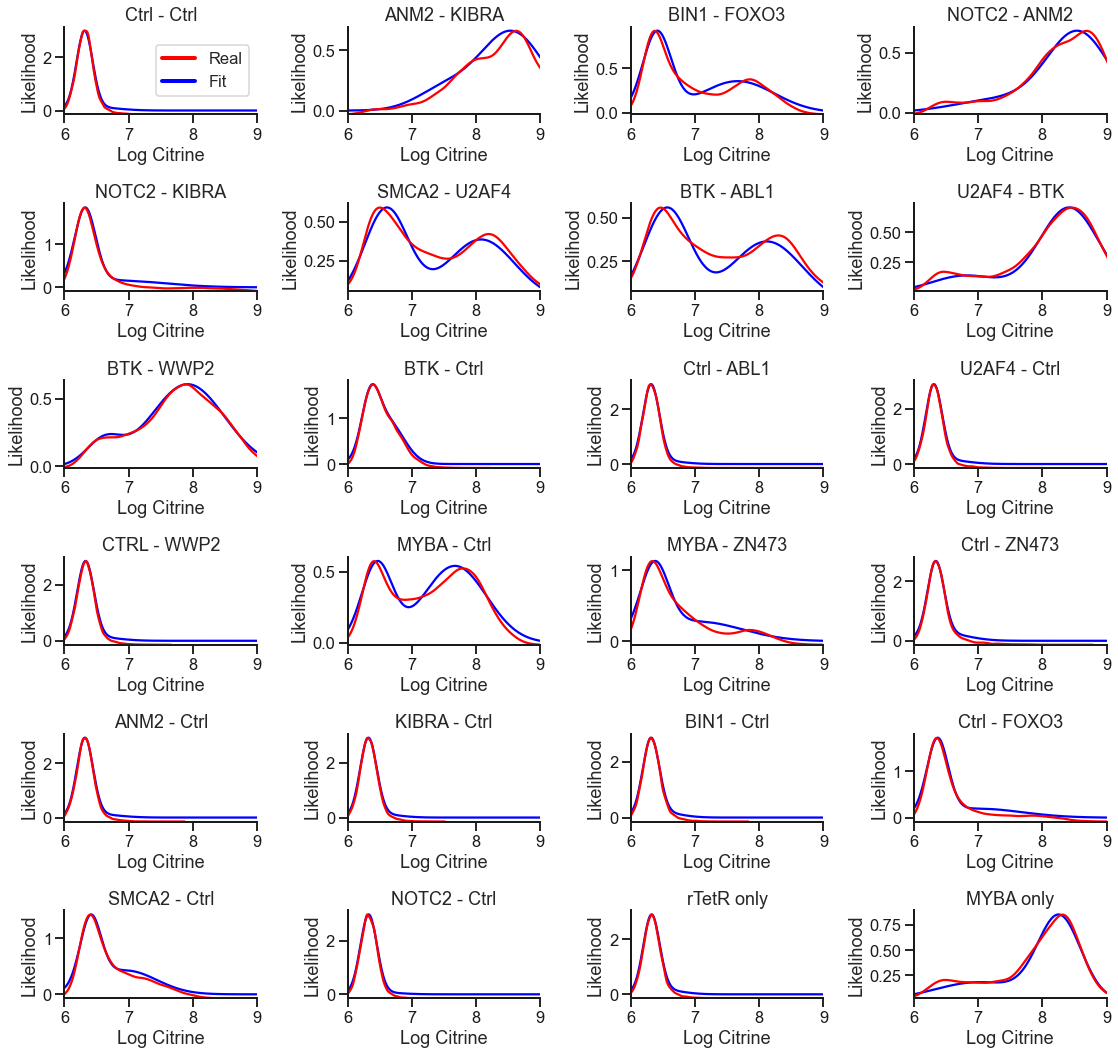

In [4]:
fig, ax = plt.subplots(6, 4, figsize=(16, 15))


def make_plasmid_plot(plasmid, ax):
    df = dx[dx["plasmid"] == plasmid]
    df = df[df["day"] == 2]
    df = df[(df["P1"]) & (df["mCherry"])]
    kde = st.gaussian_kde(np.log10(df["mCitrine-A"]))  # fit KDE to log citrine

    bp_guess = 1 - kde.integrate_box_1d(6, 7)

    name = list(df["description"])[0]

    popt, pcov = scipy.optimize.curve_fit(
        zip_pdf,
        np.linspace(6, 9),
        kde.pdf(np.linspace(6, 9)),
        p0=[bp_guess, 750, 0.25, 0.15, 6.3],
        bounds=[[1e-5, 1e-5, 0.1, 0.1, 6], [1, 2000, 5, 5, 7.5]],
    )
    #     print("Optimal parameters:", popt)

    log_c = np.linspace(6, 9, 500)
    y = zip_pdf(log_c, *popt)
    z = np.log10(df["mCitrine-A"])

    a2 = ax.twinx()
    sns.lineplot(x=log_c, y=y, ax=ax, color="blue")
    sns.kdeplot(x=z, ax=a2, color="red")

    for a in [ax, a2]:
        a.set_xlim(6, 9)
        a.set_xlabel("Log Citrine")
    ax.set_ylabel("Likelihood")
    a2.set_ylabel("")
    a2.set_yticks([])
    ax.set_title(name)

    bprime, lmbda, sigma_on, sigma_off, mu_off = popt
    #     print(f_on, beta_guess, "\t", beta, alpha, k1, gamma, sigma)
    return pd.DataFrame.from_dict(
        {
            "plasmid": [plasmid],
            "description": [name],
            "bprime": [bprime],
            "lambda": [lmbda],
            "sigma_on": [sigma_on],
            "sigma_off": [sigma_off],
            "mu_off": [mu_off],
        }
    )


popt_df = pd.concat(
    [
        make_plasmid_plot(all_plasmids[i], ax.flat[i])
        # for i in tqdm(range(3))
        for i in tqdm(range(len(all_plasmids)))
    ]
)

custom_lines = [
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="blue", lw=4),
]
ax.flat[0].legend(custom_lines, ["Real", "Fit"], loc="center right")

sns.despine(fig)
plt.tight_layout()

plt.savefig("./plots/fits.pdf", bbox_inches="tight")

In [5]:
popt_df

,plasmid,description,bprime,lambda,sigma_on,sigma_off,mu_off
0,78,Ctrl - Ctrl,0.096225,0.000010,0.336158,0.124749,6.313464
0,79,ANM2 - KIBRA,0.817699,1232.525219,0.497076,0.434397,7.500000
0,80,BIN1 - FOXO3,0.508642,698.373508,0.572154,0.220704,6.408041
0,90,NOTC2 - ANM2,0.784515,1238.572750,0.477941,0.749675,7.400196
0,91,NOTC2 - KIBRA,0.301321,168.311170,0.746749,0.162595,6.321922
0,92,SMCA2 - U2AF4,0.504200,947.017919,0.517862,0.338384,6.604999
0,125,BTK - ABL1,0.500840,971.449474,0.546275,0.359990,6.561181
0,126,U2AF4 - BTK,0.813408,1150.264575,0.456899,0.527739,6.801498
0,127,BTK - WWP2,0.875491,849.902481,0.572574,0.272703,6.614698
0,129,BTK - Ctrl,0.603850,67.606823,0.255155,0.138004,6.354172


# Correlating with Validation Data

In [6]:
val_df = pd.read_csv("../2022.03.03_activator_synergy/activation_data.csv")
print(list(val_df))
val_df.head()

['frankendescr', 'plasmid', 'description', 'FSC 488/10-A', 'SSC 488/10-A', 'day', 'mCherry-A', 'mCitrine-A', 'replicate', 'P1', 'mCherry', 'Citrine On', 'domain1', 'domain2', 'pair', 'type', 'enrichment_ratio_r1_d2', 'enrichment_ratio_r1_d5', 'enrichment_ratio_r2_d2', 'enrichment_ratio_r2_d5', 'enrichment_fraction_r1_d2', 'enrichment_fraction_r1_d5', 'enrichment_fraction_r2_d2', 'enrichment_fraction_r2_d5', 'bound_r1_d2', 'bound_r1_d5', 'bound_r2_d2', 'bound_r2_d5', 'unbound_r1_d2', 'unbound_r1_d5', 'unbound_r2_d2', 'unbound_r2_d5', 'norm_bound_r1_d2', 'norm_bound_r1_d5', 'norm_bound_r2_d2', 'norm_bound_r2_d5', 'norm_unbound_r1_d2', 'norm_unbound_r1_d5', 'norm_unbound_r2_d2', 'norm_unbound_r2_d5', 'avg_enrichment_d2', 'avg_enrichment_d5', 'domain1_screen', 'domain2_screen', 'd1_Gene', 'd1_Pathway', 'd1_Description', 'd2_Gene', 'd2_Pathway', 'd2_Description', 'd1_avg_d2.x', 'd1_sd_d2.x', 'd1_avg_d5.x', 'd1_sd_d5.x', 'd1_description.x', 'd2_avg_d2.x', 'd2_sd_d2.x', 'd1_avg_d2.y', 'd1_med

,frankendescr,plasmid,description,FSC 488/10-A,SSC 488/10-A,day,mCherry-A,mCitrine-A,replicate,P1,...,act_hit,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5
0,DMD_control_tiles;ENSG00000198947;;297; --- DM...,78,Ctrl - Ctrl,6.935798e+08,2.015884e+08,2.0,1.686651e+08,2.275942e+06,1.321569,1.0,...,False,False,-0.481389,-0.300723,0.880544,-0.481389,-0.300723,0.880544,-2.371911,3.017499
1,ANM2 --- KIBRA,79,ANM2 - KIBRA,6.851799e+08,2.079998e+08,2.0,2.095951e+08,4.312927e+08,1.668377,1.0,...,True,False,-1.019050,-0.726941,-5.645672,0.243639,0.312334,-6.707792,-0.120025,3.256295
2,BIN1 --- FOXO3,80,BIN1 - FOXO3,6.459822e+08,1.896686e+08,2.0,1.316208e+08,4.082577e+07,1.379701,1.0,...,True,True,2.683747,1.246747,1.224325,1.492156,1.681687,-8.389172,1.378309,1.267080
3,NOTC2 --- ANM2,90,NOTC2 - ANM2,6.645409e+08,2.004126e+08,2.0,1.899924e+08,3.851975e+08,1.566755,1.0,...,True,False,0.759808,0.077752,-5.258400,-1.019050,-0.726941,-5.645672,-0.888663,3.056657
4,NOTC2 --- KIBRA,91,NOTC2 - KIBRA,6.430370e+08,1.876871e+08,2.0,1.775196e+08,2.096878e+07,1.503989,1.0,...,True,True,0.759808,0.077752,-5.258400,0.243639,0.312334,-6.707792,-0.184195,2.636461


In [7]:
pdf = (
    popt_df.set_index("plasmid")
    .join(val_df.set_index("plasmid"), on="plasmid", how="left", rsuffix="_val")
    .reset_index()
)
print(list(pdf))
pdf = pdf[
    [
        "plasmid",
        "description",
        "avg_enrichment_d2",
        "composition",
        "character",
        "Citrine On",
        "mCitrine-A",
        "bprime",
        "lambda",
        "sigma_on",
        "sigma_off",
        "mu_off",
    ]
]
print(pdf.shape)
pdf = pdf.dropna()
print(pdf.shape)
pdf.head()

['plasmid', 'description', 'bprime', 'lambda', 'sigma_on', 'sigma_off', 'mu_off', 'frankendescr', 'description_val', 'FSC 488/10-A', 'SSC 488/10-A', 'day', 'mCherry-A', 'mCitrine-A', 'replicate', 'P1', 'mCherry', 'Citrine On', 'domain1', 'domain2', 'pair', 'type', 'enrichment_ratio_r1_d2', 'enrichment_ratio_r1_d5', 'enrichment_ratio_r2_d2', 'enrichment_ratio_r2_d5', 'enrichment_fraction_r1_d2', 'enrichment_fraction_r1_d5', 'enrichment_fraction_r2_d2', 'enrichment_fraction_r2_d5', 'bound_r1_d2', 'bound_r1_d5', 'bound_r2_d2', 'bound_r2_d5', 'unbound_r1_d2', 'unbound_r1_d5', 'unbound_r2_d2', 'unbound_r2_d5', 'norm_bound_r1_d2', 'norm_bound_r1_d5', 'norm_bound_r2_d2', 'norm_bound_r2_d5', 'norm_unbound_r1_d2', 'norm_unbound_r1_d5', 'norm_unbound_r2_d2', 'norm_unbound_r2_d5', 'avg_enrichment_d2', 'avg_enrichment_d5', 'domain1_screen', 'domain2_screen', 'd1_Gene', 'd1_Pathway', 'd1_Description', 'd2_Gene', 'd2_Pathway', 'd2_Description', 'd1_avg_d2.x', 'd1_sd_d2.x', 'd1_avg_d5.x', 'd1_sd_d5.x

,plasmid,description,avg_enrichment_d2,composition,character,Citrine On,mCitrine-A,bprime,lambda,sigma_on,sigma_off,mu_off
0,78,Ctrl - Ctrl,-1.852399,C-C,Control,0.007634,2.275942e+06,0.096225,0.000010,0.336158,0.124749,6.313464
1,79,ANM2 - KIBRA,5.136020,A-A,Activator,0.968464,4.312927e+08,0.817699,1232.525219,0.497076,0.434397,7.500000
2,80,BIN1 - FOXO3,3.090096,R-A,Both,0.478623,4.082577e+07,0.508642,698.373508,0.572154,0.220704,6.408041
3,90,NOTC2 - ANM2,4.922436,A-A,Activator,0.934332,3.851975e+08,0.784515,1238.572750,0.477941,0.749675,7.400196
4,91,NOTC2 - KIBRA,1.467041,A-A,Activator,0.158689,2.096878e+07,0.301321,168.311170,0.746749,0.162595,6.321922


In [8]:
mfi_df = pd.read_csv(
    "../../../Co-Recruit Paper/github_repo/fig_2/02_activator_validations/data/mfi_data.csv"
)
pdf = (
    pdf.set_index("plasmid")
    .join(mfi_df.set_index("plasmid"), on="plasmid", how="left", rsuffix="_mfi")
    .reset_index()
)
pdf.head()

,plasmid,description,avg_enrichment_d2,composition,character,Citrine On,mCitrine-A,bprime,lambda,sigma_on,sigma_off,mu_off,date,f_on,mfi
0,78,Ctrl - Ctrl,-1.852399,C-C,Control,0.007634,2.275942e+06,0.096225,0.000010,0.336158,0.124749,6.313464,2021/11/15,0.009423,2.039563e+06
1,78,Ctrl - Ctrl,-1.852399,C-C,Control,0.007634,2.275942e+06,0.096225,0.000010,0.336158,0.124749,6.313464,2022/03/03,0.007634,2.275942e+06
2,79,ANM2 - KIBRA,5.136020,A-A,Activator,0.968464,4.312927e+08,0.817699,1232.525219,0.497076,0.434397,7.500000,2021/11/15,0.954545,2.661060e+08
3,79,ANM2 - KIBRA,5.136020,A-A,Activator,0.968464,4.312927e+08,0.817699,1232.525219,0.497076,0.434397,7.500000,2022/03/03,0.968464,4.312927e+08
4,80,BIN1 - FOXO3,3.090096,R-A,Both,0.478623,4.082577e+07,0.508642,698.373508,0.572154,0.220704,6.408041,2021/11/15,0.663269,5.698616e+07


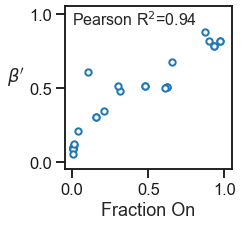

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=pdf,
    x="Citrine On",
    y="bprime",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["Citrine On"], pdf["bprime"])

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])

ax.text(x=0, y=0.92, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Fraction On")
ax.set_ylabel(r"$\beta'$", rotation="horizontal", ha="right")

fig.savefig("./plots/fon_vs_bprime.pdf", bbox_inches="tight")

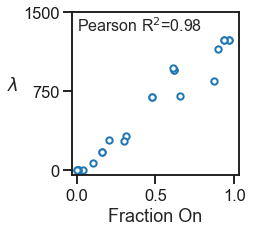

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=pdf,
    x="Citrine On",
    y="lambda",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["Citrine On"], pdf["lambda"])

ax.set_ylim(-50, 1500)
ax.set_xlim(-0.03, 1.03)

ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 750, 1500])

ax.text(x=0, y=1325, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Fraction On")
ax.set_ylabel(r"$\lambda$", rotation="horizontal", ha="right")

fig.savefig("./plots/fon_vs_lambda.pdf", bbox_inches="tight")

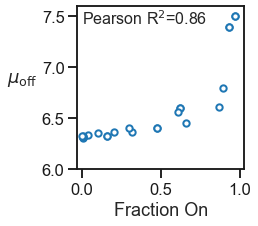

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=pdf,
    x="Citrine On",
    y="mu_off",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["Citrine On"], pdf["sigma_off"])

ax.set_ylim(6, 7.6)
ax.set_xlim(-0.03, 1.03)

ax.set_xticks([0, 0.5, 1])
ax.set_yticks([6, 6.5, 7, 7.5])

ax.text(x=0, y=7.43, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Fraction On")
ax.set_ylabel(r"$\mu_{\mathrm{off}}$", rotation="horizontal", ha="right")

fig.savefig("./plots/fon_vs_muoff.pdf", bbox_inches="tight")

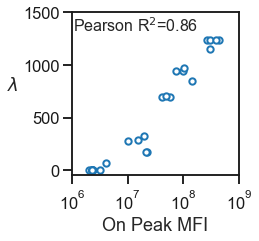

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=pdf,
    x="mfi",
    y="lambda",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["mfi"], pdf["lambda"])

ax.set_ylim(-50, 1500)
ax.set_yticks([0, 500, 1000, 1500])

ax.set_xscale("log")
ax.set_xlim(1e6, 1e9)
ax.set_xticks([1e6, 1e7, 1e8, 1e9])

ax.text(x=1.05e6, y=1325, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("On Peak MFI")
ax.set_ylabel(r"$\lambda$", rotation="horizontal", ha="right")

fig.savefig("./plots/mfi_vs_lambda.pdf", bbox_inches="tight")

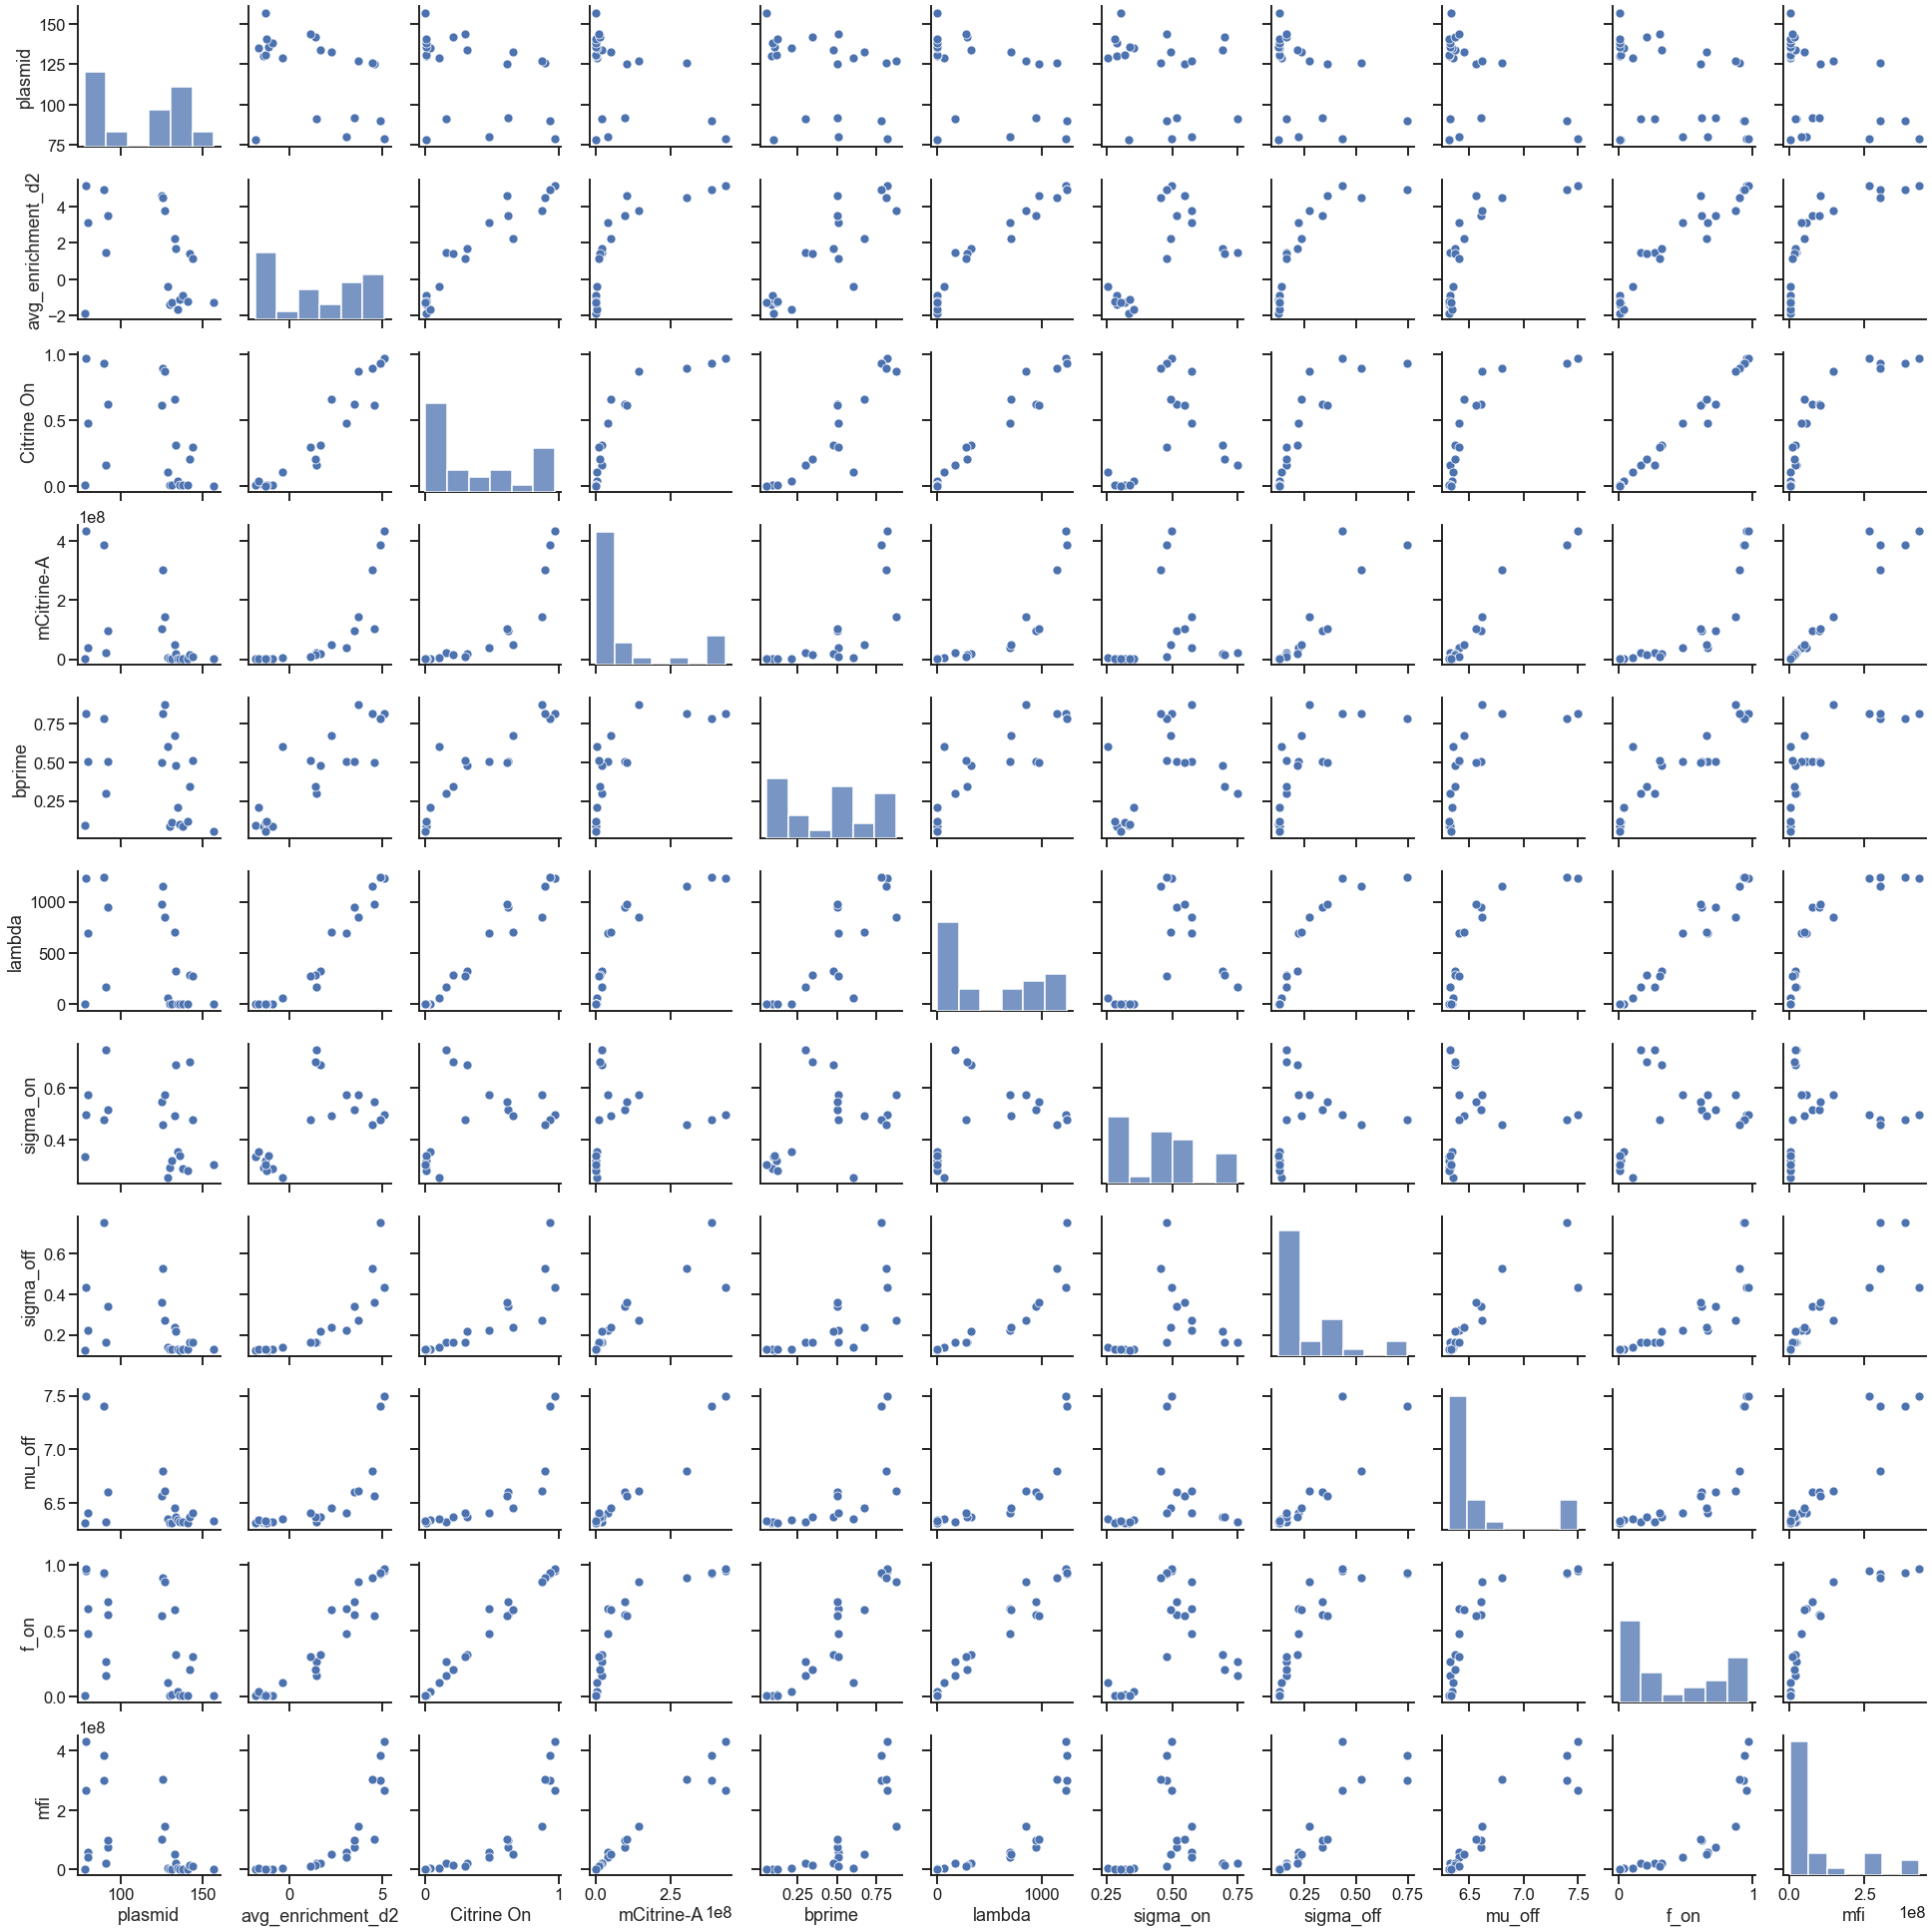

In [13]:
f = sns.pairplot(pdf)

f.savefig("./plots/correlogram.pdf", bbox_inches = "tight")

# Predicting Parameters from Screen Data

In [14]:
print(np.min(pdf["avg_enrichment_d2"]), np.max(pdf["avg_enrichment_d2"]))


def relu(x, intercept, slope, threshold):
    return intercept + (x >= threshold) * slope * (x - threshold)

-1.852399333543794 5.136019617051213


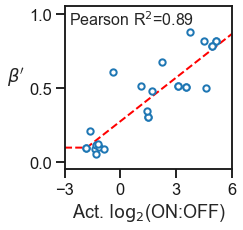

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

bp_popt, pcov = scipy.optimize.curve_fit(
    relu,
    pdf["avg_enrichment_d2"],
    pdf["bprime"],
    p0=[0, 1, 0],
    bounds=[[0, 0, -6], [1, 10, 6]],
)
xv = np.linspace(-3, 6)
yv = relu(xv, *bp_popt)
ax.plot(xv, yv, color="red", lw=2, linestyle="--", zorder=-10)

sns.scatterplot(
    data=pdf,
    x="avg_enrichment_d2",
    y="bprime",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["avg_enrichment_d2"], pdf["bprime"])

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-3, 6)

ax.set_xticks([-3, 0, 3, 6])
ax.set_yticks([0, 0.5, 1])

ax.text(x=-2.75, y=0.92, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Act. $\log_2$(ON:OFF)")
ax.set_ylabel(r"$\beta'$", rotation="horizontal", ha="right")

fig.savefig("./plots/screend2_vs_bprime.pdf", bbox_inches="tight")

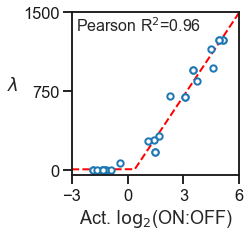

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

lm_popt, pcov = scipy.optimize.curve_fit(
    relu,
    pdf["avg_enrichment_d2"],
    pdf["lambda"],
    p0=[0, 1, 0],
    bounds=[[0, 0, -6], [1500, 15000, 6]],
)
xv = np.linspace(-3, 6, num=1000)
yv = relu(xv, *lm_popt)
ax.plot(xv, yv, color="red", lw=2, linestyle="--", zorder=-10)

sns.scatterplot(
    data=pdf,
    x="avg_enrichment_d2",
    y="lambda",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["avg_enrichment_d2"], pdf["lambda"])

ax.set_xlim(-3, 6)
ax.set_xticks([-3, 0, 3, 6])

ax.set_ylim(-50, 1500)
ax.set_yticks([0, 750, 1500])

ax.text(x=-2.75, y=1325, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Act. $\log_2$(ON:OFF)")
ax.set_ylabel(r"$\lambda$", rotation="horizontal", ha="right")

fig.savefig("./plots/screend2_vs_lambda.pdf", bbox_inches="tight")

[6.34958996 0.54494539 3.24928004]


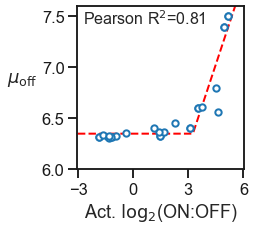

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))

mu_popt, pcov = scipy.optimize.curve_fit(
    relu,
    pdf["avg_enrichment_d2"],
    pdf["mu_off"],
    p0=[6.5, 1, 0],
    bounds=[[6, 0, -6], [8, 20, 6]],
)
print(mu_popt)
xv = np.linspace(-3, 6, num=1000)
yv = relu(xv, *mu_popt)
ax.plot(xv, yv, color="red", lw=2, linestyle="--", zorder=-10)

sns.scatterplot(
    data=pdf,
    x="avg_enrichment_d2",
    y="mu_off",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["avg_enrichment_d2"], pdf["sigma_off"])

ax.set_ylim(6, 7.6)
ax.set_xlim(-3.05, 6.05)

ax.set_xticks([-3, 0, 3, 6])
ax.set_yticks([6, 6.5, 7, 7.5])

ax.text(x=-2.75, y=7.43, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Act. $\log_2$(ON:OFF)")
ax.set_ylabel(r"$\mu_{\mathrm{off}}$", rotation="horizontal", ha="right")

fig.savefig("./plots/screen_d2_vs_muoff.pdf", bbox_inches="tight")

[0.14961944 0.17014994 2.59145725]


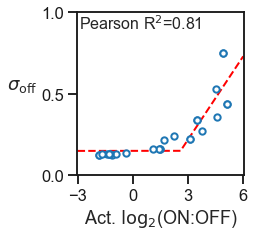

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))

so_popt, pcov = scipy.optimize.curve_fit(
    relu,
    pdf["avg_enrichment_d2"],
    pdf["sigma_off"],
    p0=[0, 1, 0],
    bounds=[[0, 0, -6], [1, 10, 6]],
)
print(so_popt)
xv = np.linspace(-3, 6, num=1000)
yv = relu(xv, *so_popt)
ax.plot(xv, yv, color="red", lw=2, linestyle="--", zorder=-10)

sns.scatterplot(
    data=pdf,
    x="avg_enrichment_d2",
    y="sigma_off",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)

r, p = st.pearsonr(pdf["avg_enrichment_d2"], pdf["sigma_off"])

ax.set_xlim(-3.05, 6.05)
ax.set_xticks([-3, 0, 3, 6])

ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])

ax.text(x=-2.9, y=0.9, s="Pearson R$^2$={:.2f}".format(r), fontsize=16)

ax.set_xlabel("Act. $\log_2$(ON:OFF)")
ax.set_ylabel(r"$\sigma_{\mathrm{off}}$", rotation="horizontal", ha="right")

fig.savefig("./plots/screen_d2_vs_sigmaoff.pdf", bbox_inches="tight")

In [19]:
def estimate_bprime(d2_score):
    return relu(d2_score, *bp_popt)


def estimate_lambda(d2_score):
    return relu(d2_score, *lm_popt)


def estimate_mu_off(d2_score):
    return relu(d2_score, *mu_popt)


sigma_on_est = np.mean(pdf["sigma_on"])


def estimate_sigma_on(d2_score):
    return sigma_on_est


def estimate_sigma_off(d2_score):
    return relu(d2_score, *so_popt)


def estimate_cit_pdf(d2_score):
    return lambda x: zip_pdf(
        x,
        estimate_bprime(d2_score),
        estimate_lambda(d2_score),
        estimate_sigma_on(d2_score),
        estimate_sigma_off(d2_score),
        estimate_mu_off(d2_score),
    )

  0%|          | 0/3 [00:00<?, ?it/s]

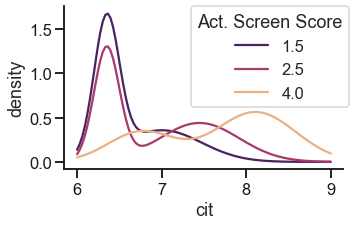

In [57]:
# Let's plot some example histograms

scorevals = [1.5, 2.5, 4.0]


def compute_cit_df(d2_score):
    likelihood = estimate_cit_pdf(d2_score)
    xv = np.linspace(6, 9, num=100)
    yv = likelihood(xv)
    return pd.DataFrame.from_dict(
        {"cit": list(xv), "density": list(yv), "d2_score": [d2_score for x in xv]}
    )


cit_df = pd.concat([compute_cit_df(s) for s in tqdm(scorevals)])

fig, ax = plt.subplots(figsize=(5, 3))

g = sns.lineplot(
    data=cit_df,
    x="cit",
    y="density",
    hue="d2_score",
    palette="flare_r",
    legend = "full",
    ax=ax,
)

l = ax.legend(title = "Act. Screen Score", bbox_to_anchor=(1.05, 1.05))

sns.despine(fig)

In [53]:
list(screen[screen['d1_Gene']=='KIBRA']['d1_med_d2'])[0]

1.3079512422618225

# Comparing Predicted Parameters with Screen Baseline Sums Data

In [21]:
screen = pd.read_csv(
    "../../../Co-Recruit Paper/github_repo/fig_2/01_activators_synergy/pairs_baselinesums.csv"
)
screen.head()

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,2.054285,0.493242,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.351655,0.582309,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,-0.808308,0.670493,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.745666,0.626952,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,1.827117,0.364559,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896


In [22]:
# parameters: bprime, lambda, sigma_off, mu_off
screen["d1_bprime"] = estimate_bprime(screen["d1_med_d2"])
screen["d1_lambda"] = estimate_lambda(screen["d1_med_d2"])
screen["d1_sigma_off"] = estimate_sigma_off(screen["d1_med_d2"])
screen["d1_mu_off"] = estimate_mu_off(screen["d1_med_d2"])

screen["d2_bprime"] = estimate_bprime(screen["d2_med_d2"])
screen["d2_lambda"] = estimate_lambda(screen["d2_med_d2"])
screen["d2_sigma_off"] = estimate_sigma_off(screen["d2_med_d2"])
screen["d2_mu_off"] = estimate_mu_off(screen["d2_med_d2"])

screen["combo_bprime"] = estimate_bprime(screen["avg_enrichment_d2"])
screen["combo_lambda"] = estimate_lambda(screen["avg_enrichment_d2"])
screen["combo_sigma_off"] = estimate_sigma_off(screen["avg_enrichment_d2"])
screen["combo_mu_off"] = estimate_mu_off(screen["avg_enrichment_d2"])

screen["sum_bprime"] = screen["d1_bprime"] + screen["d2_bprime"]
screen["sum_lambda"] = screen["d1_lambda"] + screen["d2_lambda"]
screen["sum_sigma_off"] = screen["d1_sigma_off"] + screen["d2_sigma_off"]
screen["sum_mu_off"] = screen["d1_mu_off"] + screen["d2_mu_off"]

adf = screen[screen["composition"].isin(["A-A", "C-C"])]

screen.head()

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_sigma_off,d2_mu_off,combo_bprime,combo_lambda,combo_sigma_off,combo_mu_off,sum_bprime,sum_lambda,sum_sigma_off,sum_mu_off
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,0.149619,6.34959,0.622445,845.414905,0.311772,6.510446,0.658932,625.515916,0.316055,12.69918
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.215660,6.34959,0.563513,686.300040,0.209746,6.349590,1.133858,1391.047337,0.431320,12.69918
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,0.149619,6.34959,0.096225,6.760693,0.149619,6.349590,0.192450,13.521387,0.299239,12.69918
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.167363,6.34959,0.530203,596.364793,0.152078,6.349590,1.078065,1240.405586,0.334727,12.69918
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,0.149619,6.34959,0.129946,6.760693,0.149619,6.349590,0.243707,13.521387,0.299239,12.69918


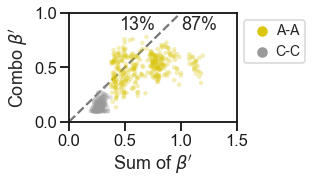

In [196]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.scatterplot(
    data=adf,
    x="sum_bprime",
    y="combo_bprime",
    hue="composition",
    linewidth=0,
    marker=".",
    alpha=0.3,
    palette=["#dbc60d", "#999999"],
    ax=ax,
)


less_df = adf[adf["sum_bprime"] >= adf["combo_bprime"]]
more_df = adf[adf["sum_bprime"] < adf["combo_bprime"]]
frac_combo_more = more_df.shape[0] / (more_df.shape[0] + less_df.shape[0]) * 100
frac_combo_less = less_df.shape[0] / (more_df.shape[0] + less_df.shape[0]) * 100


ax.text(x=0.45, y=0.85, s="{:.0f}%".format(frac_combo_more))
ax.text(x=1.0, y=0.85, s="{:.0f}%".format(frac_combo_less))


ax.set_xlabel(r"Sum of $\beta'$")
ax.set_xlim(0, 1.5)
ax.set_xticks([0, 0.5, 1.0, 1.5])

ax.set_ylabel(r"Combo $\beta'$")
ax.set_ylim(0, 1.0)
ax.set_yticks([0, 0.5, 1.0])

ax.axline([0, 0], slope=1, color="#777777", linestyle="--", zorder=-10)
leg = ax.legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize=14,
    markerscale=1.0,
    borderpad=0.3,
    handletextpad=0,
)

plt.savefig("./plots/sumbprime_vs_comboprime.pdf", bbox_inches="tight")

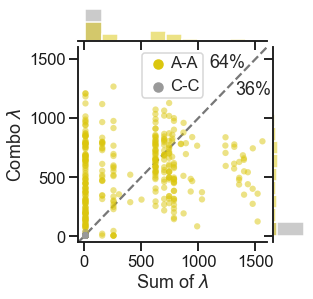

In [238]:
g = sns.JointGrid(
    data=adf,
    x="sum_lambda",
    y="combo_lambda",
    hue="composition",
    palette=["#dbc60d", "#999999"],
    height=4.5,
    marginal_ticks=False,
)

g.plot_joint(
    sns.scatterplot,
    linewidth=0,
#     marker=".",
    s=40,
    alpha=0.5,
)
g.plot_marginals(sns.histplot)

sum_less_df = adf[adf["combo_lambda"] > adf["sum_lambda"]]
sum_more_df = adf[adf["combo_lambda"] <= adf["sum_lambda"]]

frac_sum_more = more_df.shape[0] / (more_df.shape[0] + less_df.shape[0]) * 100
frac_sum_less = less_df.shape[0] / (more_df.shape[0] + less_df.shape[0]) * 100

g.ax_joint.text(x=1100, y=1425, s="{:.0f}%".format(frac_sum_less))
g.ax_joint.text(x=1325, y=1200, s="{:.0f}%".format(frac_sum_more))

g.ax_joint.axline([0, 0], slope=1, color="#777777", linestyle="--", zorder=-10)

g.ax_joint.set_xlim(-50, 1600)
g.ax_joint.set_ylim(-50, 1600)
g.ax_joint.set_xticks([0, 500, 1000, 1500])
g.ax_joint.set_yticks([0, 500, 1000, 1500])
g.ax_joint.set_xlabel(r"Sum of $\lambda$")
g.ax_joint.set_ylabel(r"Combo $\lambda$")

leg = g.ax_joint.legend(
    markerscale=1.0,
    borderpad=0.2,
    handletextpad=0,
    handlelength=1.5,
    bbox_to_anchor=(0.5, 0.7),
)


plt.savefig("./plots/sumlambda_vs_combolambda.pdf", bbox_inches="tight")

# The sub-additivity paradox

Can sub-additive work in both $\beta'$ and $\lambda$ still produce overall supra-additive properties? 

In [25]:
np.linspace(0, 1, num=4)

array([0.        , 0.33333333, 0.66666667, 1.        ])

  0%|          | 0/4 [00:00<?, ?it/s]

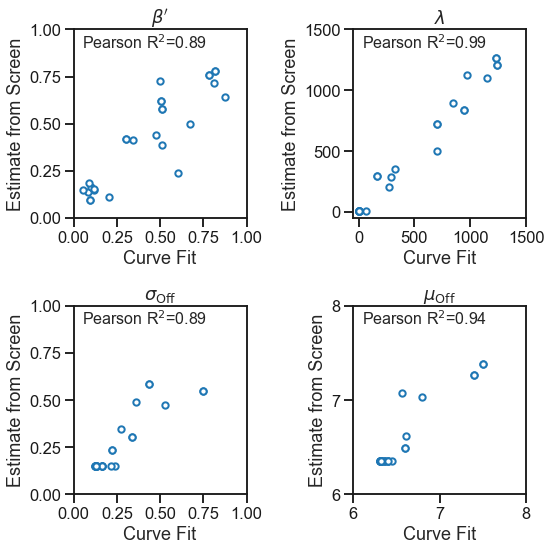

In [241]:
param_titles = [
    r"$\beta'$",
    r"$\lambda$",
    r"$\sigma_\mathrm{Off}$",
    r"$\mu_\mathrm{Off}$",
]

params = ["bprime", "lambda", "sigma_off", "mu_off"]
est_funs = [estimate_bprime, estimate_lambda, estimate_sigma_off, estimate_mu_off]

lower_lims = [0, -50, 0, 6]
upper_lims = [1, 1500, 1, 8]
ticksets = [
    [0, 0.25, 0.5, 0.75, 1.0],
    [0, 500, 1000, 1500],
    [0, 0.25, 0.5, 0.75, 1.0],
    [6, 7, 8],
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in tqdm(range(len(params))):
    ax = axes.flat[i]

    xvals = pdf[params[i]]
    yvals = est_funs[i](pdf["avg_enrichment_d2"])
    ax.scatter(
        xvals,
        yvals,
        color="white",
        edgecolor="tab:blue",
        s=40,
        linewidth=2,
    )

    ax.set_title(param_titles[i])

    ax.set_xlim(lower_lims[i], upper_lims[i])
    ax.set_ylim(lower_lims[i], upper_lims[i])

    ax.set_xticks(ticksets[i])
    ax.set_yticks(ticksets[i])

    ax.set_xlabel("Curve Fit")
    ax.set_ylabel("Estimate from Screen")

    r, p = st.pearsonr(xvals, yvals)
    limdelta = upper_lims[i] - lower_lims[i]
    ax.text(
        x=0.05 * limdelta + lower_lims[i],
        y=0.9 * limdelta + lower_lims[i],
        s="Pearson R$^2$={:.2f}".format(r),
        fontsize=16,
    )

plt.tight_layout()

plt.savefig("./plots/screen_params_vs_fit_values.pdf", bbox_inches="tight")

In [118]:
# from params, compute fraction on, compare to avg_enrichment_d2???
def compute_fon_from_params(bprime, lmbda, sigma_on, sigma_off, mu_off):
    likelihood = lambda c: zip_pdf(c, bprime, lmbda, sigma_on, sigma_off, mu_off)
    f_on = 1 - (
        scipy.integrate.quad(likelihood, 6, 7)[0]
        / scipy.integrate.quad(likelihood, 6, 9)[0]
    )
    return f_on


def compute_fon_from_screen(d2_score):
    likelihood = estimate_cit_pdf(d2_score)
    f_on = 1 - (
        scipy.integrate.quad(likelihood, 6, 7)[0]
        / scipy.integrate.quad(likelihood, 6, 9)[0]
    )
    return f_on

In [132]:
# Beta vs fraction on

scores = np.linspace(-3, 6, num = 100)
betas = [estimate_bprime(s) for s in tqdm(scores)]
lambdas = [estimate_lambda(s) for s in tqdm(scores)]
fons = [compute_fon_from_screen(s) for s in tqdm(scores)]

sbfdf = pd.DataFrame.from_dict({
    'score' : scores,
    'beta' : betas,
    'lambda': lambdas,
    'fon' : fons
})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

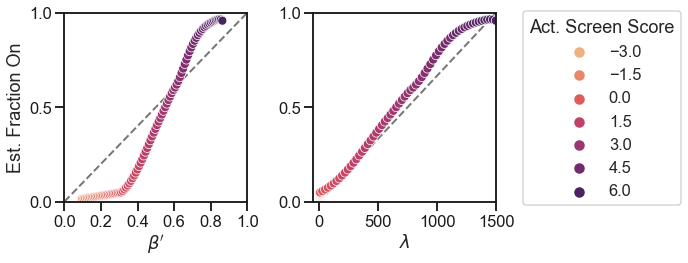

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(
    data=sbfdf,
    x="beta",
    y="fon",
    hue="score",
    palette="flare",
    legend="brief",
    ax=ax[0],
)

sns.scatterplot(
    data=sbfdf,
    x="lambda",
    y="fon",
    hue="score",
    palette="flare",
    legend="brief",
    ax=ax[1],
)

ax[0].legend().set_visible(False)
l = ax[1].legend(title="Act. Screen Score", bbox_to_anchor=(1.1, 1.05), markerscale=1.0)

ax[0].set_xlabel(r"$\beta'$")
ax[0].set_ylabel("Est. Fraction On")
ax[0].set_xlim(0, 1)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax[1].set_xlabel(r"$\lambda$")
ax[1].set_ylabel("")
ax[1].set_xlim(-50, 1500)
ax[1].set_xticks([0, 500, 1000, 1500])

for a in ax:
    a.set_ylim(0, 1)
    a.set_yticks([0, 0.5, 1])

plt.tight_layout()


ax[0].axline((0,0), slope=1, color="#777777", linestyle="--", lw=2, zorder=-10)
ax[1].axline((0,0), slope=1/1500, color="#777777", linestyle="--", lw=2, zorder=-10)

plt.savefig("./plots/est_fon_from_bprime_lamba.pdf", bbox_inches = "tight")

Everything is linear in everything else, or at least ReLU-like, so how on earth are we getting synergy? Lambda??

The problem seems to be this: the screen says everything is *sub-additive* in both $\beta'$ and $\lambda$, but *super-additive* in the average screen score. However, both $\beta'$ and $\lambda$ are linear in the average screen score! What on earth is happening! 